In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN  && python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.82 MiB | 31.20 MiB/s, done.
Resolving deltas: 100% (577/577), done.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdis

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np 
import pandas as pd 
import os, sys
from matplotlib import pyplot as plt 
import cv2 as cv2

ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR)
from numpy  import zeros, asarray, expand_dims, mean
from mrcnn.utils import Dataset, extract_bboxes, compute_ap
from mrcnn.visualize import display_instances, display_images
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

import warnings
warnings.filterwarnings("ignore")


In [9]:
data_labels = pd.read_csv('/VGG_annotation_cars.csv')


In [10]:
data_labels.__len__()

559

In [11]:
data_labels.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [12]:
data_labels.describe()

,xmin,ymin,xmax,ymax
count,559.000000,559.000000,559.000000,559.000000
mean,263.387486,186.517539,365.324845,231.500472
std,207.368388,9.315974,213.501175,13.987176
min,0.000000,148.399292,28.556446,198.321729
25%,61.387844,180.109294,166.309696,223.225547
50%,236.746744,187.524131,348.585579,230.561454
75%,446.835022,193.881918,571.322721,237.897362
max,645.183792,208.064672,676.000000,308.322072


In [17]:
class CarsDataset(Dataset):
    def load_dataset(self, dataset_dir='/content/drive/MyDrive/MLI/Resources', mode='train'):
        self.add_class('dataset',1,'car')
        if mode=='train':
            images_dir = dataset_dir + '/training_images/'
            for i in range(500):
                image_id = data_labels.iloc[i,0]
                img_path = images_dir + image_id
                self.add_image('dataset', image_id=image_id, path=img_path)
        if mode=='val':
            images_dir = dataset_dir + '/training_images/'
            for i in range(500,len(data_labels)):
                image_id = data_labels.iloc[i,0]
                img_path = images_dir + image_id
                self.add_image('dataset', image_id=image_id, path=img_path)
        if mode=='test':
            images_dir = dataset_dir + '/testing_images/'
            for filename in os.listdir(images_dir):
                image_id = filename
                img_path = images_dir + filename
                self.add_image('dataset', image_id=image_id, path=img_path)
        
    def extract_boxes(self, filename):
        boxes = list()
        xmin = int(data_labels[data_labels['image']==filename].iloc[0,1])
        ymin = int(data_labels[data_labels['image']==filename].iloc[0,2])
        xmax = int(data_labels[data_labels['image']==filename].iloc[0,3])
        ymax = int(data_labels[data_labels['image']==filename].iloc[0,4])
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
        width = 380
        height = 676
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        file = info['id']
        boxes, w, h = self.extract_boxes(file)
        masks = zeros([w, h, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('car'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [16]:
train_set = CarsDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

val_set = CarsDataset()
val_set.load_dataset(mode='val')
val_set.prepare()
print('Validate: %d' % len(val_set.image_ids))
 
test_set = CarsDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 500
Validate: 59


FileNotFoundError: ignored

In [ ]:
def plot(num_img=5):
    for i in range(num_img):
        image_id = np.random.randint(0,len(train_set.image_ids))
        image = train_set.load_image(image_id)
        mask, class_ids = train_set.load_mask(image_id)
        plt.imshow(image)
        plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
        plt.show()

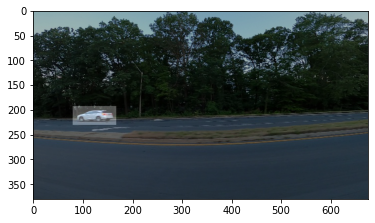

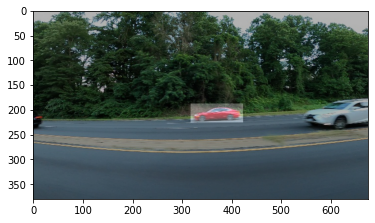

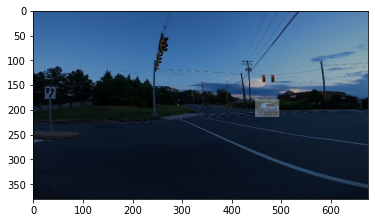

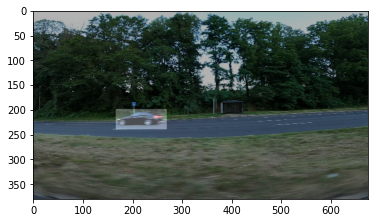

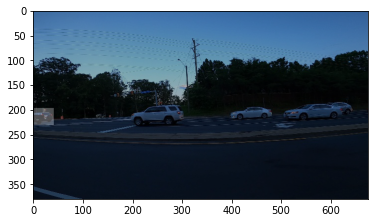

In [ ]:
plot()

In [ ]:
class MLI_cars_config(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 20
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 448
    
config = MLI_cars_config()

In [ ]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [ ]:
model.load_weights('/content/drive/MyDrive/MLI/Resources/mask_rcnn_coco.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./cars_cfg20210905T0443/mask_rcnn_cars_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNo